# Router
- LLM이 특정 상황에서 다음에 실행할 노드를 결정하도록 함

In [1]:
from dotenv import load_dotenv
from pprint import pprint

load_dotenv()

True

In [10]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4.1')

# 커스텀 Tool 생성
def multiply(a: int, b: int) -> int:
    """Multiply a and b
    Args:
        a: first int
        b: second int
    """
    return a * b


llm_with_tools = llm.bind_tools([multiply])

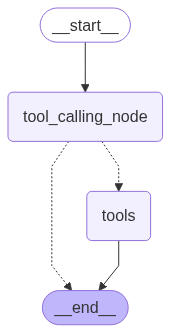

In [11]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState  # 08에서 직접 만든 State와 같음
from langgraph.prebuilt import ToolNode, tools_condition

# Node 정의
def tool_calling_node(state: MessagesState):
    new_messages = [ llm_with_tools.invoke(state['messages']) ]
    return {
        'messages': new_messages
    }

# 그래프 빌드
builder = StateGraph(MessagesState)
builder.add_node('tool_calling_node', tool_calling_node)
builder.add_node('tools', ToolNode([multiply]))

builder.add_edge(START, 'tool_calling_node')
builder.add_conditional_edges(
    'tool_calling_node',
    # tool_calling_node의 결과가 'tool_calls' 라면 -> tools 노드로 보냄
    # tool_calling_node의 결과가 'tool_calls'가 아니면 -> 바로 답변 생성
    tools_condition
)
builder.add_edge('tools', END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
from langchain_core.messages import HumanMessage
messages = [
    HumanMessage(content='2 랑 삼이랑 곱하면?')
]
res = graph.invoke({'messages': messages})

In [13]:
for m in res['messages']:
    m.pretty_print()

================================ Human Message =================================

2 랑 삼이랑 곱하면?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_JO1YdFTyHjEdVFiEB3f2XN8H)
 Call ID: call_JO1YdFTyHjEdVFiEB3f2XN8H
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
